In [23]:
# Import libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Paths to datasets
train_path = r"C:\Users\Nana Casmana\Downloads\Garbage Classification-20241121T105258Z-001\Garbage Classification\newdataset\train"
valid_path = r"C:\Users\Nana Casmana\Downloads\Garbage Classification-20241121T105258Z-001\Garbage Classification\newdataset\valid"
test_path = r"C:\Users\Nana Casmana\Downloads\Garbage Classification-20241121T105258Z-001\Garbage Classification\newdataset\test"
model_save_path = r"C:\Users\Nana Casmana\Downloads\Garbage Classification-20241121T105258Z-001\Garbage Classification\newdataset\best_model_vgg.keras"

In [24]:
# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [25]:
# Rescaling for validation and testing
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Generators
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_directory(
    valid_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 4921 images belonging to 5 classes.
Found 542 images belonging to 5 classes.
Found 559 images belonging to 5 classes.


In [26]:
# Load pre-trained VGG16
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [27]:
# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(5, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

In [28]:
# Compile model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(filepath=model_save_path, monitor='val_loss', save_best_only=True)

In [29]:
# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5,
    callbacks=[early_stop, model_checkpoint]
)

c:\Program Files\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 435s 3s/step - accuracy: 0.2452 - loss: 1.6722 - val_accuracy: 0.2620 - val_loss: 1.5464
Epoch 2/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 431s 3s/step - accuracy: 0.3983 - loss: 1.4271 - val_accuracy: 0.3358 - val_loss: 1.5075
Epoch 3/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 431s 3s/step - accuracy: 0.5281 - loss: 1.2169 - val_accuracy: 0.3542 - val_loss: 1.5246
Epoch 4/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 431s 3s/step - accuracy: 0.5741 - loss: 1.0960 - val_accuracy: 0.4170 - val_loss: 1.5448
Epoch 5/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 430s 3s/step - accuracy: 0.6088 - loss: 0.9842 - val_accuracy: 0.4225 - val_loss: 1.4991
Epoch 6/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 432s 3s/step - accuracy: 0.6407 - loss: 0.9154 - val_accuracy: 0.4613 - val_loss: 1.5089
Epoch 7/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 430s 3s/step - accuracy: 0.6695 - loss: 0.8747 - val_accuracy: 0.4779 - val_loss: 1.4333
Epoch 8/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 432s 3s/step - accuracy: 0.6753 - loss: 0.8389 - val_accu

In [ ]:
# Fine-tuning: Unfreeze top layers of VGG16
for layer in base_model.layers[-4:]:
    layer.trainable = True

# Re-compile the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Continue training with fine-tuning
fine_tune_history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[early_stop, model_checkpoint]
)

In [30]:
model.save(r"C:\Users\Nana Casmana\Downloads\Garbage Classification-20241121T105258Z-001\Garbage Classification\newdataset\final_model_vgg.h5")

In [31]:
# Evaluate on test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

18/18 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.5953 - loss: 1.0210
Test Accuracy: 54.92%
Test Loss: 1.1505


In [ ]:
# Classification Report and Confusion Matrix
test_preds = model.predict(test_generator)
test_pred_classes = np.argmax(test_preds, axis=1)
true_classes = test_generator.classes
class_labels = list(train_generator.class_indices.keys())

# Classification Report
print(classification_report(true_classes, test_pred_classes, target_names=class_labels))

In [ ]:
# Confusion Matrix
conf_matrix = confusion_matrix(true_classes, test_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
# Visualization of training history
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'] + fine_tune_history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'] + fine_tune_history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'] + fine_tune_history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'] + fine_tune_history.history['val_loss'], label='Validation Loss')
plt.title('Training History')
plt.xlabel('Epochs')
plt.ylabel('Accuracy / Loss')
plt.legend()
plt.show()

In [33]:
# Predict a single image
def predict_image(image_path, model, class_labels):
    img = load_img(image_path, target_size=(224, 224))  # Resize image
    img_array = img_to_array(img) / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)  # Expand dimensions for batch
    
    # Predict
    prediction = model.predict(img_array)
    predicted_class = class_labels[np.argmax(prediction)]
    confidence = np.max(prediction) * 100
    
    # Display the image and prediction
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {predicted_class} ({confidence:.2f}%)")
    plt.show()

# Example: Predict a single image
test_image_path = r"C:\Users\Nana Casmana\Downloads\Garbage Classification\newdataset\test\Kaleng\R_2100.jpg"
predict_image(test_image_path, model, class_labels)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


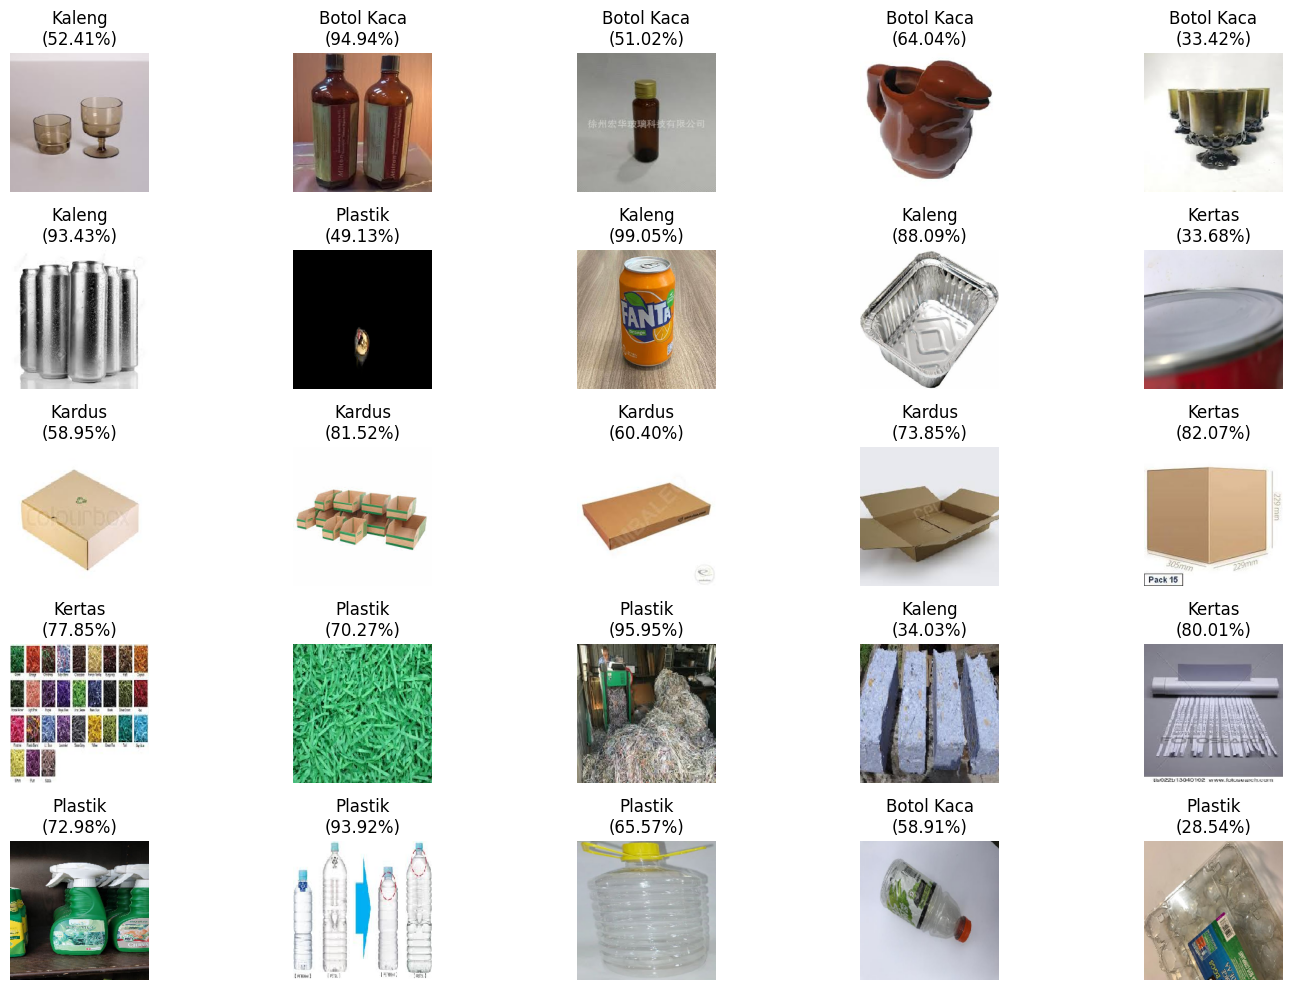

In [42]:
# Predict batch of images
def predict_batch_images(test_path, model, class_labels, num_images=5):
    test_categories = os.listdir(test_path)
    plt.figure(figsize=(15, 10))
    
    count = 0
    for category in test_categories:
        category_path = os.path.join(test_path, category)
        images = os.listdir(category_path)[:num_images]
        
        for image_name in images:
            img_path = os.path.join(category_path, image_name)
            img = load_img(img_path, target_size=(224, 224))
            img_array = img_to_array(img) / 255.0
            img_array = np.expand_dims(img_array, axis=0)
            
            # Predict
            prediction = model.predict(img_array)
            predicted_class = class_labels[np.argmax(prediction)]
            confidence = np.max(prediction) * 100
            
            # Display the image and prediction
            plt.subplot(len(test_categories), num_images, count + 1)
            plt.imshow(img)
            plt.axis('off')
            plt.title(f"{predicted_class}\n({confidence:.2f}%)")
            count += 1
    plt.tight_layout()
    plt.show()

# Example: Predict a batch of images
predict_batch_images(test_path, model, class_labels, num_images=5)
